# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [8]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [10]:
%load_ext autoreload

In [11]:
%autoreload 2

from boosting import Boosting

### Проверка кода

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9075
Test ROC-AUC 0.9051


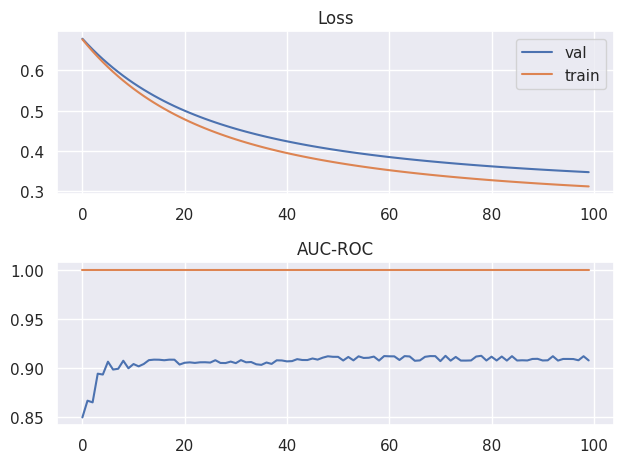

In [ ]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label='val')

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9030
Test ROC-AUC 0.9004


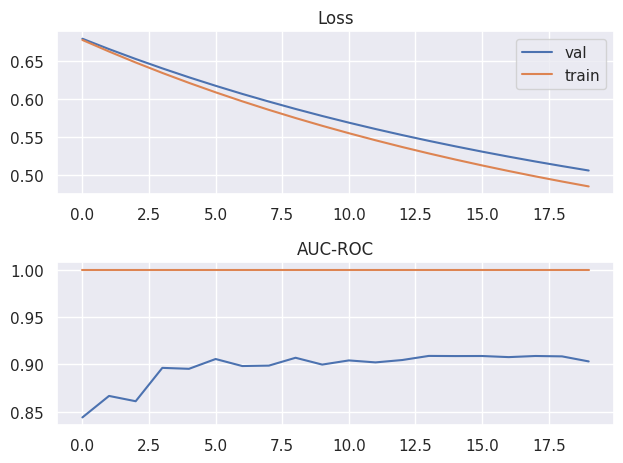

In [ ]:
boosting = Boosting(n_estimators=100, early_stopping_rounds=2, eval_set=(X_valid, y_valid))

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** вероятнее всего, обучение просто надолго затянется, а результат будет таким же, так как так или иначе просто обучим линейную модель.</font>

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [63]:
!pip install xgboost

In [72]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
xgbooster = XGBClassifier(n_estimators=100, booster  = 'gbliner')

In [73]:
%%time
bst = xgb.train(param, dtrain, num_round)

XGBoostError: [20:48:51] /workspace/src/gbm/gbm.cc:26: Unknown gbm type gbliner
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x7e5339a2dcbc]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xdfea8) [0x7e53398dfea8]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x5c95df) [0x7e5339dc95df]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x5caf4d) [0x7e5339dcaf4d]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7e533993752f]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7e53b4aa1e2e]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7e53b4a9e493]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7e53b4ac73e9]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x7e53b4ac6a00]



In [62]:
boosting.plot_history(X_val, y_val)

NameError: name 'X_val' is not defined

Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** ...</font>

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** Посредством бутстрапа снижается корреляция между отдельными деревьями, что ведет к улучшению по разбросу, но ухудшению по смещению </font>

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9171
Test ROC-AUC 0.9135


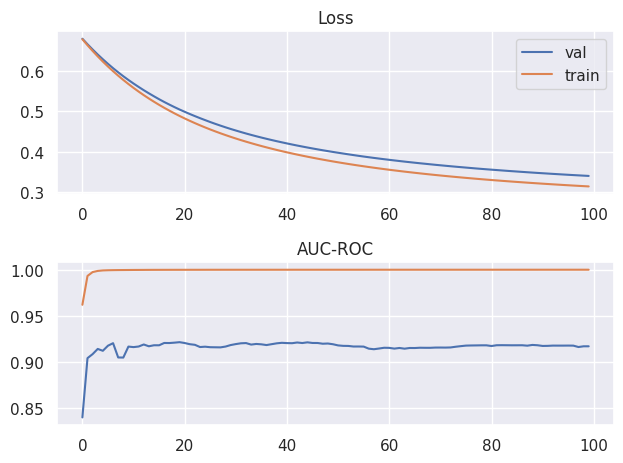

In [47]:
boosting = Boosting(n_estimators=100, subsample = 0.7, bootstrap_type = 'Bernoulli')

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9059
Test ROC-AUC 0.9039


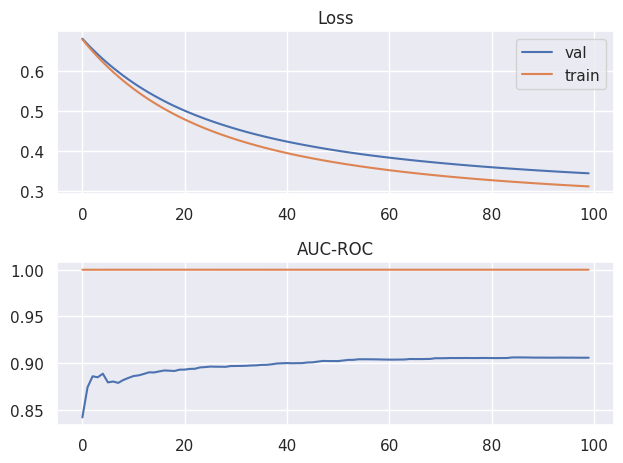

In [48]:
boosting = Boosting(n_estimators=100, bagging_temperature = 3, bootstrap_type = 'Bayesian')

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**: При квантизации выбросы (как правило) перестанут быть выбросами. Так как если их количество статистически неважно, то они попадут в бин с значением, которые не является выбросом. Наны тоже обработать легче, можем назначать им медианный бин, тем самым они будут слабо влиять на предикт.

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)? Можно, но нужно</font>

<font color='plum'>**Ответ**: ... </font>

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9292
Test ROC-AUC 0.9225


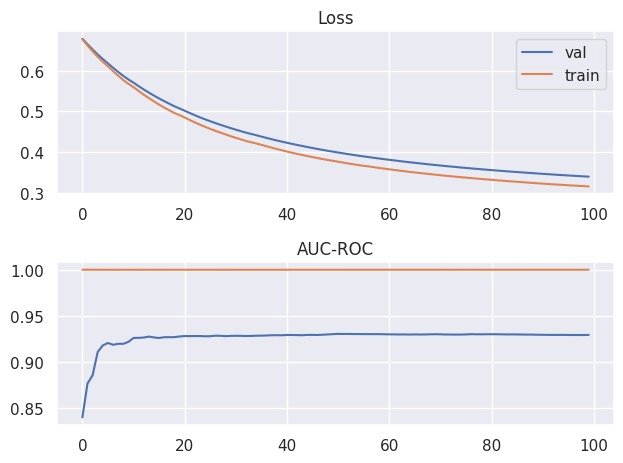

In [64]:
boosting = Boosting(n_estimators=100, rsm = 0.7)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')


Train ROC-AUC 0.9998
Valid ROC-AUC 0.9033
Test ROC-AUC 0.9053


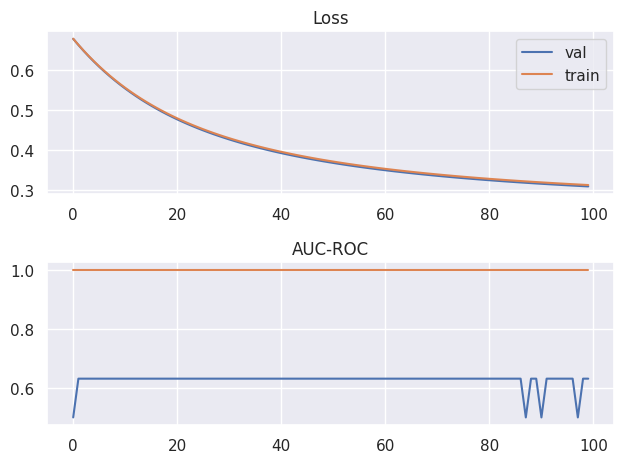

In [62]:
boosting = Boosting(n_estimators=100, quantization_type = 'Uniform', nbins = 300)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9884
Valid ROC-AUC 0.8719
Test ROC-AUC 0.8736


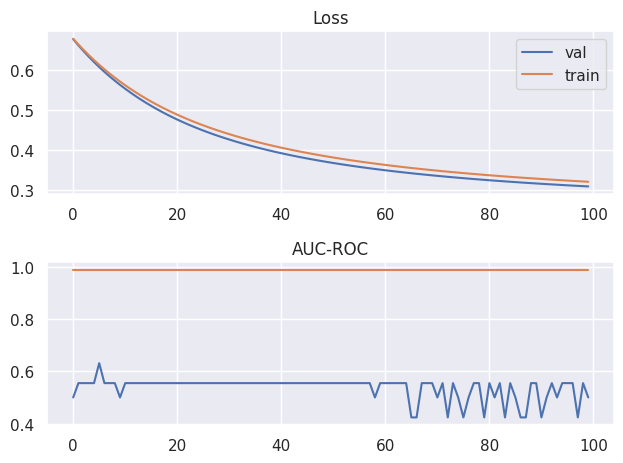

In [65]:
boosting = Boosting(n_estimators=100, quantization_type = 'Quantile', nbins = 300)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. Квантизация (1.5 балл)

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="Piecewise"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9075
Test ROC-AUC 0.9050
[3.68227616e-03 9.54899081e-03 4.19021911e-03 2.49380771e-03
 4.08066908e-03 2.26087948e-03 1.46044889e-03 2.42675007e-04
 1.03680505e-03 2.68931360e-03 2.89890901e-03 1.41421196e-03
 3.97169416e-03 4.70155009e-05 4.82480178e-04 1.63709328e-03
 5.69640524e-05 3.79017224e-04 1.35730251e-06 1.66474730e-03
 8.35034388e-03 6.62218897e-03 1.32172199e-03 1.00969469e-03
 8.24506609e-03 3.31573376e-03 1.16074600e-15 3.23307551e-03
 2.53063120e-04 7.24281411e-04 2.59120486e-03 1.70287001e-03
 9.12968481e-04 1.59719986e-04 1.02996997e-03 4.05049768e-03
 2.34962017e-02 1.97367839e-03 2.82688556e-04 8.25136414e-16
 5.42751068e-04 0.00000000e+00 8.85793181e-05 3.93469709e-04
 3.07518077e-18 2.91234979e-04 4.70580427e-04 3.07365394e-04
 4.24924023e-04 5.03727587e-19 5.81321894e-04 4.53069654e-04
 7.30512300e-04 1.68312859e-04 1.31173988e-04 1.73914765e-04
 8.07609917e-05 1.22901881e-03 0.00000000e+00 1.84235085e-03
 3.88805599e-04 9.49942

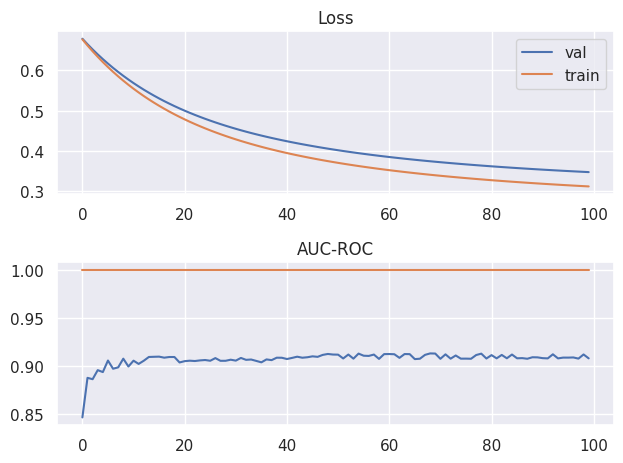

In [67]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid, label = 'val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')
print(boosting.feature_importances_)

Покажите, какие признаки оказались самыми важными

In [68]:
ind = np.argpartition(boosting.feature_importances_, -10)[-10:]
print(*ind)
print(*boosting.feature_importances_[ind])

167 161 162 142 158 164 165 166 36 168
0.015094439414815362 0.015455472135166284 0.016536576202827964 0.020496057293722527 0.02260643095728073 0.3020284546493961 0.05134736858323359 0.9488681543917243 0.023496201685170644 0.05133768045678327


### Бонус. DART (1.5 балла)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [5]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [79]:
import optuna

def objective(trial, model="custom_boosting"):
    # параметры, общие для всех бустингов
    tree_params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10)
    }
    common_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "base_model_params":tree_params,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "bootstrap_type": trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        "rsm": trial.suggest_float("rsm", 0.5, 1),
        "quantization_type": trial.suggest_categorical('quantization_type', [None, 'Uniform', 'Quantile']),
    }
    # параметры для конкретной имплементации бустинга
    optional_params = {}
    if common_params["bootstrap_type"] == "Bernoulli":
      optional_params["subsample"] = trial.suggest_float("subsample", 0.5, 1)
    if common_params["bootstrap_type"] == "Bayesian":
      optional_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.2, 100)
    if common_params["quantization_type"] != None:
      optional_params["nbins"] = trial.suggest_int("nbins", 100, 500)
    params = common_params | optional_params
    np.random.seed(1337)
    model = Boosting(**params)
    model.fit(X_train, y_train)

    return model.loss_fn(y_valid, model.predict_proba(X_valid)[:, 1])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, timeout=600)

print("Best params:", study.best_params)
print("Best loss:", study.best_value)

[I 2024-12-22 17:53:23,724] A new study created in memory with name: no-name-65fe9ddb-2ece-4d69-9b4c-3743dfa47758
[I 2024-12-22 18:13:53,251] Trial 0 finished with value: 0.44507019577737467 and parameters: {'max_depth': 6, 'n_estimators': 884, 'learning_rate': 0.6860704782469811, 'bootstrap_type': 'Bayesian', 'rsm': 0.5055506205721241, 'quantization_type': None, 'bagging_temperature': 21.16326761897342}. Best is trial 0 with value: 0.44507019577737467.


Best params: {'max_depth': 6, 'n_estimators': 884, 'learning_rate': 0.6860704782469811, 'bootstrap_type': 'Bayesian', 'rsm': 0.5055506205721241, 'quantization_type': None, 'bagging_temperature': 21.16326761897342}
Best loss: 0.44507019577737467


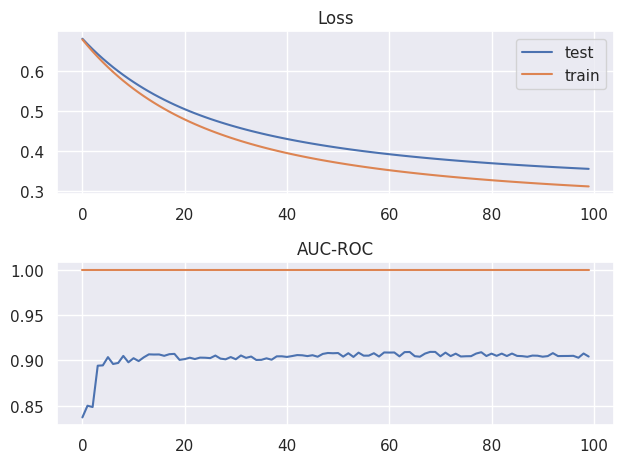

In [80]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_test, y_test, label='test')

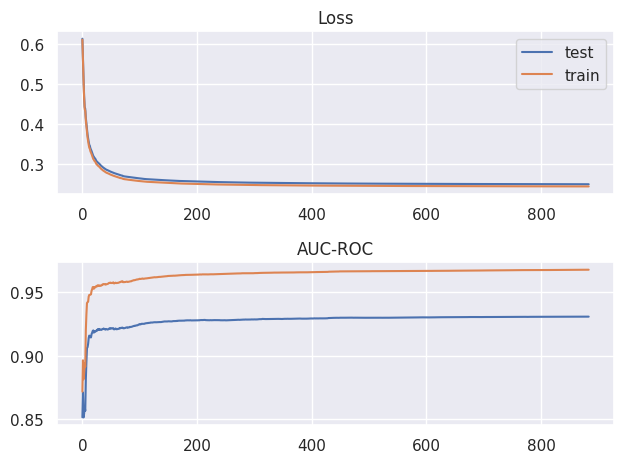

In [93]:
boosting = Boosting(n_estimators=study.best_params['n_estimators'],
                    base_model_params={"max_depth": study.best_params["max_depth"]},
                    learning_rate=study.best_params['learning_rate'],
                    bootstrap_type=study.best_params['bootstrap_type'],
                    rsm = study.best_params['rsm'],
                    quantization_type = study.best_params['quantization_type'],
                    bagging_temperature = study.best_params['bagging_temperature'],
                    )

boosting.fit(X_train, y_train)
boosting.plot_history(X_test, y_test, label='test')

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [12]:
%%time
import optuna
import time
from optuna.pruners import WilcoxonPruner
def objective(trial, model="custom_boosting"):
    # параметры, общие для всех бустингов
    tree_params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10)
    }
    common_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "base_model_params":tree_params,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "bootstrap_type": trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        "rsm": trial.suggest_float("rsm", 0.5, 1),
        "quantization_type": trial.suggest_categorical('quantization_type', [None, 'Uniform', 'Quantile']),
    }
    # параметры для конкретной имплементации бустинга
    optional_params = {}
    if common_params["bootstrap_type"] == "Bernoulli":
      optional_params["subsample"] = trial.suggest_float("subsample", 0.5, 1)
    if common_params["bootstrap_type"] == "Bayesian":
      optional_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.2, 100)
    if common_params["quantization_type"] != None:
      optional_params["nbins"] = trial.suggest_int("nbins", 100, 500)
    params = common_params | optional_params
    np.random.seed(1337)
    model = Boosting(**params)
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    trial.set_user_attr('train_loss', model.history['train_loss'])
    trial.set_user_attr('fit_time', elapsed_time)

    return model.loss_fn(y_valid, model.predict_proba(X_valid)[:,1])

pruner = WilcoxonPruner(p_threshold=0.1)
study = optuna.create_study(direction='minimize', storage="sqlite:////content/optimization.db", pruner = pruner)
study.optimize(objective, n_trials=30, timeout=600)

print("Best params:", study.best_params)
print("Best loss:", study.best_value)

[I 2024-12-22 19:42:47,872] A new study created in RDB with name: no-name-19a37521-57f6-43de-a651-33b0e362fdd1
[I 2024-12-22 19:50:56,207] Trial 0 finished with value: 0.46304594084293654 and parameters: {'max_depth': 1, 'n_estimators': 315, 'learning_rate': 0.0469215086648362, 'bootstrap_type': 'Bernoulli', 'rsm': 0.8681072374094472, 'quantization_type': 'Quantile', 'subsample': 0.7998524424068345, 'nbins': 411}. Best is trial 0 with value: 0.46304594084293654.
[I 2024-12-22 19:54:27,987] Trial 1 finished with value: 0.4599376431336709 and parameters: {'max_depth': 5, 'n_estimators': 168, 'learning_rate': 0.13683681177871512, 'bootstrap_type': 'Bayesian', 'rsm': 0.522349765838614, 'quantization_type': 'Uniform', 'bagging_temperature': 81.71135862249294, 'nbins': 323}. Best is trial 1 with value: 0.4599376431336709.


Best params: {'max_depth': 5, 'n_estimators': 168, 'learning_rate': 0.13683681177871512, 'bootstrap_type': 'Bayesian', 'rsm': 0.522349765838614, 'quantization_type': 'Uniform', 'bagging_temperature': 81.71135862249294, 'nbins': 323}
Best loss: 0.4599376431336709
CPU times: user 10min 32s, sys: 10.7 s, total: 10min 43s
Wall time: 11min 40s


11min 40s

In [13]:
!pip install optuna optuna-dashboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.6 MB/s eta 0:00:00


In [14]:
# Нашел на https://stackoverflow.com/questions/76033104/launching-optuna-dashboard-in-google-colaboratory
import time
import threading
from optuna_dashboard import wsgi
import optuna
from wsgiref.simple_server import make_server
port = 1234
storage = optuna.storages.RDBStorage("sqlite:////content/optimization.db")
app = wsgi(storage)
httpd = make_server("localhost", port, app)
thread = threading.Thread(target=httpd.serve_forever)
thread.start()
time.sleep(3) # Wait until the server startup

from google.colab import output
output.serve_kernel_port_as_window(port, path='/dashboard/')

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

CPU times: user 3min 14s, sys: 955 ms, total: 3min 15s
Wall time: 3min 41s


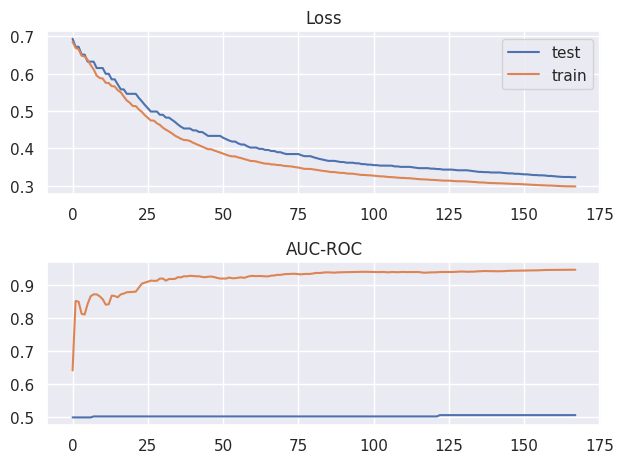

In [25]:
%%time
boosting = Boosting(n_estimators=study.best_params['n_estimators'],
                    base_model_params={"max_depth": study.best_params["max_depth"]},
                    learning_rate=study.best_params['learning_rate'],
                    bootstrap_type=study.best_params['bootstrap_type'],
                    rsm = study.best_params['rsm'],
                    quantization_type = study.best_params['quantization_type'],
                    bagging_temperature = study.best_params['bagging_temperature'],
                    )

boosting.fit(X_train, y_train)
boosting.plot_history(X_test, y_test, label='test')

### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [16]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [24]:
from catboost import CatBoostClassifier, metrics
from sklearn.metrics import log_loss
def objective(trial, model="custom_boosting"):
    # параметры, общие для всех бустингов
    common_params = {
        "loss_function": 'Logloss',
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.9),
        "bootstrap_type": trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        "rsm": trial.suggest_float("rsm", 0.5, 1)
    }
    # параметры для конкретной имплементации бустинга
    optional_params = {}
    if common_params["bootstrap_type"] == "Bernoulli":
      optional_params["subsample"] = trial.suggest_float("subsample", 0.5, 1)
    if common_params["bootstrap_type"] == "Bayesian":
      optional_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.2, 10)
    params = common_params | optional_params
    np.random.seed(1337)
    model = CatBoostClassifier(**params)
    start_time = time.time()
    model.fit(X_train, y_train, eval_set = (X_valid, y_valid))
    elapsed_time = time.time() - start_time

    return log_loss(y_valid, model.predict_proba(X_valid)[:, 1])

study_cat = optuna.create_study(direction='minimize', storage="sqlite:////content/optimization_cat.db")
study_cat.optimize(objective, n_trials=25, timeout=300)

print("Best params:", study_cat.best_params)
print("Best loss:", study_cat.best_value)

[I 2024-12-22 20:04:17,937] A new study created in RDB with name: no-name-451360d6-8eba-4fb4-886b-93499c0070ba


0:	learn: 0.6581460	test: 0.6596244	best: 0.6596244 (0)	total: 47ms	remaining: 19.4s
1:	learn: 0.6257351	test: 0.6285160	best: 0.6285160 (1)	total: 77.9ms	remaining: 16s
2:	learn: 0.5946541	test: 0.5987391	best: 0.5987391 (2)	total: 138ms	remaining: 18.9s
3:	learn: 0.5664522	test: 0.5718009	best: 0.5718009 (3)	total: 183ms	remaining: 18.7s
4:	learn: 0.5402471	test: 0.5474017	best: 0.5474017 (4)	total: 220ms	remaining: 17.9s
5:	learn: 0.5190070	test: 0.5275220	best: 0.5275220 (5)	total: 262ms	remaining: 17.8s
6:	learn: 0.5013520	test: 0.5112477	best: 0.5112477 (6)	total: 289ms	remaining: 16.7s
7:	learn: 0.4836067	test: 0.4948144	best: 0.4948144 (7)	total: 307ms	remaining: 15.5s
8:	learn: 0.4692579	test: 0.4816931	best: 0.4816931 (8)	total: 324ms	remaining: 14.5s
9:	learn: 0.4540093	test: 0.4673711	best: 0.4673711 (9)	total: 357ms	remaining: 14.4s
10:	learn: 0.4407784	test: 0.4555066	best: 0.4555066 (10)	total: 402ms	remaining: 14.7s
11:	learn: 0.4272529	test: 0.4430722	best: 0.4430722 (

[I 2024-12-22 20:04:22,441] Trial 0 finished with value: 0.28522935417217155 and parameters: {'n_estimators': 413, 'max_depth': 6, 'learning_rate': 0.0310250304470627, 'bootstrap_type': 'Bernoulli', 'rsm': 0.9432155456555436, 'subsample': 0.9425475814465429}. Best is trial 0 with value: 0.28522935417217155.


406:	learn: 0.1902551	test: 0.2854951	best: 0.2852294 (355)	total: 3.76s	remaining: 55.5ms
407:	learn: 0.1900997	test: 0.2855096	best: 0.2852294 (355)	total: 3.77s	remaining: 46.2ms
408:	learn: 0.1900394	test: 0.2854839	best: 0.2852294 (355)	total: 3.78s	remaining: 37ms
409:	learn: 0.1899128	test: 0.2854180	best: 0.2852294 (355)	total: 3.79s	remaining: 27.7ms
410:	learn: 0.1898387	test: 0.2854147	best: 0.2852294 (355)	total: 3.79s	remaining: 18.5ms
411:	learn: 0.1897690	test: 0.2853822	best: 0.2852294 (355)	total: 3.8s	remaining: 9.22ms
412:	learn: 0.1896854	test: 0.2854049	best: 0.2852294 (355)	total: 3.81s	remaining: 0us

bestTest = 0.2852293542
bestIteration = 355

Shrink model to first 356 iterations.
0:	learn: 0.3629377	test: 0.3915249	best: 0.3915249 (0)	total: 8.34ms	remaining: 5.25s
1:	learn: 0.3021332	test: 0.3465908	best: 0.3465908 (1)	total: 17.2ms	remaining: 5.39s
2:	learn: 0.2851455	test: 0.3393361	best: 0.3393361 (2)	total: 25.6ms	remaining: 5.35s
3:	learn: 0.2661765	test

[I 2024-12-22 20:04:31,073] Trial 1 finished with value: 0.31076555112290816 and parameters: {'n_estimators': 630, 'max_depth': 7, 'learning_rate': 0.5778704450061326, 'bootstrap_type': 'Bayesian', 'rsm': 0.547799003249403, 'bagging_temperature': 9.24058150268645}. Best is trial 0 with value: 0.28522935417217155.


622:	learn: 0.0952947	test: 0.4079918	best: 0.3107656 (23)	total: 7.95s	remaining: 89.3ms
623:	learn: 0.0952178	test: 0.4082549	best: 0.3107656 (23)	total: 7.96s	remaining: 76.5ms
624:	learn: 0.0951786	test: 0.4084293	best: 0.3107656 (23)	total: 7.96s	remaining: 63.7ms
625:	learn: 0.0951236	test: 0.4081235	best: 0.3107656 (23)	total: 7.98s	remaining: 51ms
626:	learn: 0.0950539	test: 0.4081644	best: 0.3107656 (23)	total: 7.99s	remaining: 38.2ms
627:	learn: 0.0950199	test: 0.4082175	best: 0.3107656 (23)	total: 8s	remaining: 25.5ms
628:	learn: 0.0949925	test: 0.4083712	best: 0.3107656 (23)	total: 8s	remaining: 12.7ms
629:	learn: 0.0949486	test: 0.4086835	best: 0.3107656 (23)	total: 8.01s	remaining: 0us

bestTest = 0.3107655511
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.6017227	test: 0.6047359	best: 0.6047359 (0)	total: 16.3ms	remaining: 4.42s
1:	learn: 0.5302597	test: 0.5377151	best: 0.5377151 (1)	total: 33.2ms	remaining: 4.5s
2:	learn: 0.4739459	test: 0.4847470	

[I 2024-12-22 20:04:36,457] Trial 2 finished with value: 0.29160683731493775 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learning_rate': 0.0817801841218542, 'bootstrap_type': 'Bayesian', 'rsm': 0.5664435673993007, 'bagging_temperature': 6.326190809725678}. Best is trial 0 with value: 0.28522935417217155.


268:	learn: 0.1633864	test: 0.2998446	best: 0.2916068 (119)	total: 4.96s	remaining: 73.8ms
269:	learn: 0.1632844	test: 0.2999612	best: 0.2916068 (119)	total: 4.98s	remaining: 55.4ms
270:	learn: 0.1631815	test: 0.3003035	best: 0.2916068 (119)	total: 5s	remaining: 36.9ms
271:	learn: 0.1630661	test: 0.3002105	best: 0.2916068 (119)	total: 5.01s	remaining: 18.4ms
272:	learn: 0.1628169	test: 0.3001852	best: 0.2916068 (119)	total: 5.03s	remaining: 0us

bestTest = 0.2916068373
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 0.4137125	test: 0.4460764	best: 0.4460764 (0)	total: 5.49ms	remaining: 1s
1:	learn: 0.3972504	test: 0.4362967	best: 0.4362967 (1)	total: 11.4ms	remaining: 1.04s
2:	learn: 0.3404865	test: 0.3833172	best: 0.3833172 (2)	total: 16.9ms	remaining: 1.02s
3:	learn: 0.3330324	test: 0.3764828	best: 0.3764828 (3)	total: 22.6ms	remaining: 1.01s
4:	learn: 0.3216802	test: 0.3688500	best: 0.3688500 (4)	total: 28.2ms	remaining: 1.01s
5:	learn: 0.3010143	test: 0.3585716

[I 2024-12-22 20:04:37,897] Trial 3 finished with value: 0.31086095786106205 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.8940736770316405, 'bootstrap_type': 'Bayesian', 'rsm': 0.8829890416114222, 'bagging_temperature': 6.5062706771085645}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.5549693	test: 0.5635515	best: 0.5635515 (0)	total: 10.3ms	remaining: 9.83s
1:	learn: 0.4791819	test: 0.4929227	best: 0.4929227 (1)	total: 15.5ms	remaining: 7.38s
2:	learn: 0.4498126	test: 0.4678054	best: 0.4678054 (2)	total: 19.2ms	remaining: 6.09s
3:	learn: 0.4216398	test: 0.4410552	best: 0.4410552 (3)	total: 25.7ms	remaining: 6.11s
4:	learn: 0.4046117	test: 0.4242637	best: 0.4242637 (4)	total: 30ms	remaining: 5.71s
5:	learn: 0.3745079	test: 0.3979831	best: 0.3979831 (5)	total: 33.9ms	remaining: 5.37s
6:	learn: 0.3661288	test: 0.3907781	best: 0.3907781 (6)	total: 37.4ms	remaining: 5.07s
7:	learn: 0.3569664	test: 0.3816458	best: 0.3816458 (7)	total: 40.5ms	remaining: 4.8s
8:	learn: 0.3477240	test: 0.3732680	best: 0.3732680 (8)	total: 44.4ms	remaining: 4.67s
9:	learn: 0.3419679	test: 0.3688840	best: 0.3688840 (9)	total: 48.1ms	remaining: 4.55s
10:	learn: 0.3331779	test: 0.3631836	best: 0.3631836 (10)	total: 51ms	remaining: 4.38s
11:	learn: 0.3287992	test: 0.3598102	best: 0.3

[I 2024-12-22 20:04:44,048] Trial 4 finished with value: 0.2876901272716091 and parameters: {'n_estimators': 956, 'max_depth': 1, 'learning_rate': 0.2858508684079144, 'bootstrap_type': 'Bernoulli', 'rsm': 0.888774635745205, 'subsample': 0.841322220445151}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.4994889	test: 0.5055887	best: 0.5055887 (0)	total: 9.23ms	remaining: 5.35s
1:	learn: 0.4158672	test: 0.4315242	best: 0.4315242 (1)	total: 18.3ms	remaining: 5.3s
2:	learn: 0.3644650	test: 0.3848714	best: 0.3848714 (2)	total: 27.2ms	remaining: 5.25s
3:	learn: 0.3329730	test: 0.3585189	best: 0.3585189 (3)	total: 36.6ms	remaining: 5.27s
4:	learn: 0.3145676	test: 0.3442896	best: 0.3442896 (4)	total: 45.2ms	remaining: 5.21s
5:	learn: 0.3082523	test: 0.3390915	best: 0.3390915 (5)	total: 53.9ms	remaining: 5.17s
6:	learn: 0.2899603	test: 0.3263908	best: 0.3263908 (6)	total: 63.3ms	remaining: 5.19s
7:	learn: 0.2834853	test: 0.3224063	best: 0.3224063 (7)	total: 72.5ms	remaining: 5.19s
8:	learn: 0.2803965	test: 0.3214552	best: 0.3214552 (8)	total: 82.1ms	remaining: 5.22s
9:	learn: 0.2702806	test: 0.3156672	best: 0.3156672 (9)	total: 91.1ms	remaining: 5.2s
10:	learn: 0.2654541	test: 0.3135190	best: 0.3135190 (10)	total: 100ms	remaining: 5.2s
11:	learn: 0.2618052	test: 0.3107861	best: 0.

[I 2024-12-22 20:04:50,179] Trial 5 finished with value: 0.29462599339852574 and parameters: {'n_estimators': 581, 'max_depth': 7, 'learning_rate': 0.20452650350693488, 'bootstrap_type': 'Bayesian', 'rsm': 0.9188417135678612, 'bagging_temperature': 7.315035611422564}. Best is trial 0 with value: 0.28522935417217155.


567:	learn: 0.1327195	test: 0.3346387	best: 0.2946260 (60)	total: 5.54s	remaining: 127ms
568:	learn: 0.1326319	test: 0.3347417	best: 0.2946260 (60)	total: 5.56s	remaining: 117ms
569:	learn: 0.1325366	test: 0.3348835	best: 0.2946260 (60)	total: 5.57s	remaining: 107ms
570:	learn: 0.1324900	test: 0.3349809	best: 0.2946260 (60)	total: 5.58s	remaining: 97.6ms
571:	learn: 0.1322967	test: 0.3356408	best: 0.2946260 (60)	total: 5.58s	remaining: 87.9ms
572:	learn: 0.1322759	test: 0.3358026	best: 0.2946260 (60)	total: 5.59s	remaining: 78.1ms
573:	learn: 0.1322130	test: 0.3358129	best: 0.2946260 (60)	total: 5.6s	remaining: 68.3ms
574:	learn: 0.1321868	test: 0.3358846	best: 0.2946260 (60)	total: 5.61s	remaining: 58.5ms
575:	learn: 0.1319962	test: 0.3359095	best: 0.2946260 (60)	total: 5.62s	remaining: 48.8ms
576:	learn: 0.1319635	test: 0.3358959	best: 0.2946260 (60)	total: 5.63s	remaining: 39ms
577:	learn: 0.1319203	test: 0.3360232	best: 0.2946260 (60)	total: 5.64s	remaining: 29.3ms
578:	learn: 0.13

[I 2024-12-22 20:04:56,471] Trial 6 finished with value: 0.28993095247101996 and parameters: {'n_estimators': 631, 'max_depth': 3, 'learning_rate': 0.11796580281936982, 'bootstrap_type': 'Bayesian', 'rsm': 0.5294122847662215, 'bagging_temperature': 7.921343936055102}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.5317714	test: 0.5422558	best: 0.5422558 (0)	total: 4.71ms	remaining: 2.79s
1:	learn: 0.4427400	test: 0.4603240	best: 0.4603240 (1)	total: 12.2ms	remaining: 3.59s
2:	learn: 0.3911513	test: 0.4116458	best: 0.4116458 (2)	total: 16.5ms	remaining: 3.24s
3:	learn: 0.3695079	test: 0.3916727	best: 0.3916727 (3)	total: 20ms	remaining: 2.95s
4:	learn: 0.3507852	test: 0.3753051	best: 0.3753051 (4)	total: 23.6ms	remaining: 2.78s
5:	learn: 0.3390384	test: 0.3661415	best: 0.3661415 (5)	total: 27.9ms	remaining: 2.73s
6:	learn: 0.3204410	test: 0.3510117	best: 0.3510117 (6)	total: 31.7ms	remaining: 2.65s
7:	learn: 0.3129358	test: 0.3450807	best: 0.3450807 (7)	total: 35.7ms	remaining: 2.61s
8:	learn: 0.3066026	test: 0.3387571	best: 0.3387571 (8)	total: 40.2ms	remaining: 2.61s
9:	learn: 0.3028629	test: 0.3344996	best: 0.3344996 (9)	total: 44.5ms	remaining: 2.6s
10:	learn: 0.2946229	test: 0.3290575	best: 0.3290575 (10)	total: 48.7ms	remaining: 2.57s
11:	learn: 0.2899117	test: 0.3268390	best: 0

[I 2024-12-22 20:04:59,792] Trial 7 finished with value: 0.28756683223859747 and parameters: {'n_estimators': 593, 'max_depth': 2, 'learning_rate': 0.25406589409536545, 'bootstrap_type': 'Bernoulli', 'rsm': 0.9465160888883448, 'subsample': 0.7525136459694932}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.5517455	test: 0.5613352	best: 0.5613352 (0)	total: 5.46ms	remaining: 3.69s
1:	learn: 0.4522938	test: 0.4682140	best: 0.4682140 (1)	total: 11.3ms	remaining: 3.81s
2:	learn: 0.4043004	test: 0.4258526	best: 0.4258526 (2)	total: 16.6ms	remaining: 3.74s
3:	learn: 0.3687222	test: 0.3952440	best: 0.3952440 (3)	total: 21.6ms	remaining: 3.64s
4:	learn: 0.3431819	test: 0.3731776	best: 0.3731776 (4)	total: 26.8ms	remaining: 3.6s
5:	learn: 0.3237660	test: 0.3547488	best: 0.3547488 (5)	total: 31.9ms	remaining: 3.57s
6:	learn: 0.3118681	test: 0.3444056	best: 0.3444056 (6)	total: 37.2ms	remaining: 3.56s
7:	learn: 0.3006062	test: 0.3356800	best: 0.3356800 (7)	total: 42.5ms	remaining: 3.55s
8:	learn: 0.2900447	test: 0.3276628	best: 0.3276628 (8)	total: 47ms	remaining: 3.49s
9:	learn: 0.2856177	test: 0.3238051	best: 0.3238051 (9)	total: 63.6ms	remaining: 4.24s
10:	learn: 0.2809074	test: 0.3212158	best: 0.3212158 (10)	total: 77.6ms	remaining: 4.7s
11:	learn: 0.2769772	test: 0.3175033	best: 0.

[I 2024-12-22 20:05:04,340] Trial 8 finished with value: 0.2857753522856881 and parameters: {'n_estimators': 677, 'max_depth': 4, 'learning_rate': 0.17374496228065545, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6919628115868393, 'subsample': 0.6993807418049887}. Best is trial 0 with value: 0.28522935417217155.


658:	learn: 0.1518683	test: 0.3028944	best: 0.2857754 (75)	total: 3.93s	remaining: 107ms
659:	learn: 0.1518280	test: 0.3029110	best: 0.2857754 (75)	total: 3.94s	remaining: 101ms
660:	learn: 0.1518041	test: 0.3029468	best: 0.2857754 (75)	total: 3.94s	remaining: 95.4ms
661:	learn: 0.1517917	test: 0.3029709	best: 0.2857754 (75)	total: 3.95s	remaining: 89.4ms
662:	learn: 0.1517756	test: 0.3029299	best: 0.2857754 (75)	total: 3.95s	remaining: 83.4ms
663:	learn: 0.1516668	test: 0.3030193	best: 0.2857754 (75)	total: 3.96s	remaining: 77.5ms
664:	learn: 0.1516332	test: 0.3030517	best: 0.2857754 (75)	total: 3.96s	remaining: 71.5ms
665:	learn: 0.1515660	test: 0.3029612	best: 0.2857754 (75)	total: 3.97s	remaining: 65.5ms
666:	learn: 0.1515015	test: 0.3030146	best: 0.2857754 (75)	total: 3.97s	remaining: 59.6ms
667:	learn: 0.1514676	test: 0.3031872	best: 0.2857754 (75)	total: 3.98s	remaining: 53.6ms
668:	learn: 0.1514059	test: 0.3032103	best: 0.2857754 (75)	total: 3.98s	remaining: 47.6ms
669:	learn: 

[I 2024-12-22 20:05:10,231] Trial 9 finished with value: 0.28890991280037237 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.10766456317169269, 'bootstrap_type': 'Bayesian', 'rsm': 0.584812267157154, 'bagging_temperature': 7.314813181890254}. Best is trial 0 with value: 0.28522935417217155.


400:	learn: 0.1752918	test: 0.2940199	best: 0.2889099 (187)	total: 5.26s	remaining: 118ms
401:	learn: 0.1752172	test: 0.2940204	best: 0.2889099 (187)	total: 5.27s	remaining: 105ms
402:	learn: 0.1751078	test: 0.2940519	best: 0.2889099 (187)	total: 5.29s	remaining: 91.8ms
403:	learn: 0.1750351	test: 0.2941435	best: 0.2889099 (187)	total: 5.29s	remaining: 78.6ms
404:	learn: 0.1749921	test: 0.2941917	best: 0.2889099 (187)	total: 5.3s	remaining: 65.4ms
405:	learn: 0.1749390	test: 0.2942940	best: 0.2889099 (187)	total: 5.31s	remaining: 52.3ms
406:	learn: 0.1748825	test: 0.2942203	best: 0.2889099 (187)	total: 5.31s	remaining: 39.2ms
407:	learn: 0.1747873	test: 0.2941911	best: 0.2889099 (187)	total: 5.32s	remaining: 26.1ms
408:	learn: 0.1747456	test: 0.2942223	best: 0.2889099 (187)	total: 5.33s	remaining: 13ms
409:	learn: 0.1746875	test: 0.2943615	best: 0.2889099 (187)	total: 5.33s	remaining: 0us

bestTest = 0.2889099128
bestIteration = 187

Shrink model to first 188 iterations.
0:	learn: 0.33

[I 2024-12-22 20:05:24,762] Trial 10 finished with value: 0.2994451452857654 and parameters: {'n_estimators': 378, 'max_depth': 10, 'learning_rate': 0.4802866173121161, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7883001542202052, 'subsample': 0.9770506786972922}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.6756486	test: 0.6766642	best: 0.6766642 (0)	total: 5.53ms	remaining: 4.63s
1:	learn: 0.6585116	test: 0.6603555	best: 0.6603555 (1)	total: 10.9ms	remaining: 4.54s
2:	learn: 0.6405206	test: 0.6431571	best: 0.6431571 (2)	total: 16.6ms	remaining: 4.61s
3:	learn: 0.6246464	test: 0.6280727	best: 0.6280727 (3)	total: 21.9ms	remaining: 4.58s
4:	learn: 0.6120171	test: 0.6163952	best: 0.6163952 (4)	total: 27.2ms	remaining: 4.54s
5:	learn: 0.5983660	test: 0.6036137	best: 0.6036137 (5)	total: 35.5ms	remaining: 4.92s
6:	learn: 0.5841493	test: 0.5899388	best: 0.5899388 (6)	total: 40.8ms	remaining: 4.84s
7:	learn: 0.5728372	test: 0.5792390	best: 0.5792390 (7)	total: 45.8ms	remaining: 4.75s
8:	learn: 0.5608285	test: 0.5676915	best: 0.5676915 (8)	total: 50.9ms	remaining: 4.69s
9:	learn: 0.5478255	test: 0.5554680	best: 0.5554680 (9)	total: 56.3ms	remaining: 4.66s
10:	learn: 0.5352118	test: 0.5437197	best: 0.5437197 (10)	total: 61.8ms	remaining: 4.64s
11:	learn: 0.5239709	test: 0.5331779	best

[I 2024-12-22 20:05:30,900] Trial 11 finished with value: 0.28530099880320037 and parameters: {'n_estimators': 838, 'max_depth': 5, 'learning_rate': 0.01714302699965392, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6948872596813169, 'subsample': 0.5901258190561368}. Best is trial 0 with value: 0.28522935417217155.


0:	learn: 0.6675524	test: 0.6693239	best: 0.6693239 (0)	total: 9.82ms	remaining: 8.53s
1:	learn: 0.6455574	test: 0.6485227	best: 0.6485227 (1)	total: 16.8ms	remaining: 7.3s
2:	learn: 0.6194167	test: 0.6235398	best: 0.6235398 (2)	total: 23.1ms	remaining: 6.67s
3:	learn: 0.5969949	test: 0.6022355	best: 0.6022355 (3)	total: 28.9ms	remaining: 6.26s
4:	learn: 0.5798544	test: 0.5864361	best: 0.5864361 (4)	total: 34.3ms	remaining: 5.94s
5:	learn: 0.5631298	test: 0.5711216	best: 0.5711216 (5)	total: 40.5ms	remaining: 5.83s
6:	learn: 0.5442676	test: 0.5530401	best: 0.5530401 (6)	total: 46.3ms	remaining: 5.7s
7:	learn: 0.5299016	test: 0.5395701	best: 0.5395701 (7)	total: 52.1ms	remaining: 5.62s
8:	learn: 0.5135484	test: 0.5239997	best: 0.5239997 (8)	total: 57.6ms	remaining: 5.51s
9:	learn: 0.4991379	test: 0.5104742	best: 0.5104742 (9)	total: 63.8ms	remaining: 5.49s
10:	learn: 0.4853097	test: 0.4977875	best: 0.4977875 (10)	total: 69.8ms	remaining: 5.45s
11:	learn: 0.4719873	test: 0.4852596	best: 

[I 2024-12-22 20:05:41,171] Trial 12 finished with value: 0.2852111256095386 and parameters: {'n_estimators': 870, 'max_depth': 5, 'learning_rate': 0.026178788517136387, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7163012452118918, 'subsample': 0.5306022368129026}. Best is trial 12 with value: 0.2852111256095386.


866:	learn: 0.1855442	test: 0.2867761	best: 0.2852111 (468)	total: 9.4s	remaining: 32.5ms
867:	learn: 0.1855114	test: 0.2867905	best: 0.2852111 (468)	total: 9.41s	remaining: 21.7ms
868:	learn: 0.1854734	test: 0.2867613	best: 0.2852111 (468)	total: 9.42s	remaining: 10.8ms
869:	learn: 0.1854515	test: 0.2867847	best: 0.2852111 (468)	total: 9.43s	remaining: 0us

bestTest = 0.2852111256
bestIteration = 468

Shrink model to first 469 iterations.
0:	learn: 0.3815632	test: 0.4061991	best: 0.4061991 (0)	total: 11.8ms	remaining: 9.44s
1:	learn: 0.3095480	test: 0.3469806	best: 0.3469806 (1)	total: 23.6ms	remaining: 9.39s
2:	learn: 0.2754959	test: 0.3257750	best: 0.3257750 (2)	total: 35ms	remaining: 9.28s
3:	learn: 0.2587588	test: 0.3143079	best: 0.3143079 (3)	total: 46.4ms	remaining: 9.22s
4:	learn: 0.2440600	test: 0.3054097	best: 0.3054097 (4)	total: 57.3ms	remaining: 9.1s
5:	learn: 0.2329860	test: 0.3009904	best: 0.3009904 (5)	total: 69.4ms	remaining: 9.18s
6:	learn: 0.2273137	test: 0.2993047	b

[I 2024-12-22 20:05:53,958] Trial 13 finished with value: 0.29559429212479116 and parameters: {'n_estimators': 799, 'max_depth': 8, 'learning_rate': 0.3677880838418396, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7969527796317759, 'subsample': 0.9799317694159442}. Best is trial 12 with value: 0.2852111256095386.


795:	learn: 0.0425389	test: 0.4518834	best: 0.2955943 (11)	total: 12s	remaining: 45.1ms
796:	learn: 0.0425389	test: 0.4518839	best: 0.2955943 (11)	total: 12s	remaining: 30.1ms
797:	learn: 0.0425094	test: 0.4523172	best: 0.2955943 (11)	total: 12s	remaining: 15ms
798:	learn: 0.0424519	test: 0.4525232	best: 0.2955943 (11)	total: 12s	remaining: 0us

bestTest = 0.2955942921
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.3591704	test: 0.3868494	best: 0.3868494 (0)	total: 5.87ms	remaining: 2.56s
1:	learn: 0.2898843	test: 0.3337020	best: 0.3337020 (1)	total: 12.2ms	remaining: 2.65s
2:	learn: 0.2654719	test: 0.3244598	best: 0.3244598 (2)	total: 18.3ms	remaining: 2.65s
3:	learn: 0.2568330	test: 0.3198759	best: 0.3198759 (3)	total: 23.9ms	remaining: 2.6s
4:	learn: 0.2489023	test: 0.3183930	best: 0.3183930 (4)	total: 29.7ms	remaining: 2.57s
5:	learn: 0.2438910	test: 0.3164920	best: 0.3164920 (5)	total: 35.7ms	remaining: 2.57s
6:	learn: 0.2370579	test: 0.3139444	best: 0.313944

[I 2024-12-22 20:05:57,297] Trial 14 finished with value: 0.3004069764714695 and parameters: {'n_estimators': 438, 'max_depth': 5, 'learning_rate': 0.6822243823778742, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6943544053582943, 'subsample': 0.5676352628509364}. Best is trial 12 with value: 0.2852111256095386.


428:	learn: 0.1051416	test: 0.3714379	best: 0.3004070 (17)	total: 2.81s	remaining: 58.9ms
429:	learn: 0.1049222	test: 0.3714500	best: 0.3004070 (17)	total: 2.82s	remaining: 52.5ms
430:	learn: 0.1047509	test: 0.3709355	best: 0.3004070 (17)	total: 2.83s	remaining: 45.9ms
431:	learn: 0.1046191	test: 0.3704652	best: 0.3004070 (17)	total: 2.83s	remaining: 39.4ms
432:	learn: 0.1045964	test: 0.3704915	best: 0.3004070 (17)	total: 2.84s	remaining: 32.8ms
433:	learn: 0.1045164	test: 0.3706387	best: 0.3004070 (17)	total: 2.85s	remaining: 26.2ms
434:	learn: 0.1043989	test: 0.3710439	best: 0.3004070 (17)	total: 2.85s	remaining: 19.7ms
435:	learn: 0.1043704	test: 0.3711760	best: 0.3004070 (17)	total: 2.86s	remaining: 13.1ms
436:	learn: 0.1042652	test: 0.3716199	best: 0.3004070 (17)	total: 2.86s	remaining: 6.55ms
437:	learn: 0.1038764	test: 0.3733655	best: 0.3004070 (17)	total: 2.87s	remaining: 0us

bestTest = 0.3004069765
bestIteration = 17

Shrink model to first 18 iterations.
0:	learn: 0.3919933	t

[I 2024-12-22 20:06:13,538] Trial 15 finished with value: 0.29009609531715813 and parameters: {'n_estimators': 990, 'max_depth': 6, 'learning_rate': 0.4013258130314591, 'bootstrap_type': 'Bernoulli', 'rsm': 0.8290328533706108, 'subsample': 0.8843392533355712}. Best is trial 12 with value: 0.2852111256095386.


977:	learn: 0.0566443	test: 0.4092997	best: 0.2900961 (31)	total: 14.9s	remaining: 183ms
978:	learn: 0.0566436	test: 0.4093000	best: 0.2900961 (31)	total: 15s	remaining: 168ms
979:	learn: 0.0566342	test: 0.4092922	best: 0.2900961 (31)	total: 15s	remaining: 153ms
980:	learn: 0.0566319	test: 0.4092449	best: 0.2900961 (31)	total: 15s	remaining: 137ms
981:	learn: 0.0566149	test: 0.4092914	best: 0.2900961 (31)	total: 15s	remaining: 122ms
982:	learn: 0.0566149	test: 0.4092909	best: 0.2900961 (31)	total: 15s	remaining: 107ms
983:	learn: 0.0566041	test: 0.4093111	best: 0.2900961 (31)	total: 15s	remaining: 91.4ms
984:	learn: 0.0565717	test: 0.4095885	best: 0.2900961 (31)	total: 15s	remaining: 76.1ms
985:	learn: 0.0565539	test: 0.4099251	best: 0.2900961 (31)	total: 15s	remaining: 60.9ms
986:	learn: 0.0565537	test: 0.4099252	best: 0.2900961 (31)	total: 15s	remaining: 45.6ms
987:	learn: 0.0565285	test: 0.4099824	best: 0.2900961 (31)	total: 15s	remaining: 30.4ms
988:	learn: 0.0565165	test: 0.410022

[I 2024-12-22 20:06:33,880] Trial 16 finished with value: 0.2867705044490538 and parameters: {'n_estimators': 790, 'max_depth': 7, 'learning_rate': 0.03137246956018937, 'bootstrap_type': 'Bernoulli', 'rsm': 0.9861793924219944, 'subsample': 0.6789994313274929}. Best is trial 12 with value: 0.2852111256095386.


0:	learn: 0.3606101	test: 0.3914834	best: 0.3914834 (0)	total: 13.9ms	remaining: 6.85s
1:	learn: 0.2962274	test: 0.3393123	best: 0.3393123 (1)	total: 24.6ms	remaining: 6.04s
2:	learn: 0.2695060	test: 0.3289787	best: 0.3289787 (2)	total: 33.8ms	remaining: 5.51s
3:	learn: 0.2557900	test: 0.3167595	best: 0.3167595 (3)	total: 41.4ms	remaining: 5.07s
4:	learn: 0.2507396	test: 0.3141292	best: 0.3141292 (4)	total: 48ms	remaining: 4.68s
5:	learn: 0.2466858	test: 0.3100133	best: 0.3100133 (5)	total: 53.4ms	remaining: 4.33s
6:	learn: 0.2425970	test: 0.3079924	best: 0.3079924 (6)	total: 58.8ms	remaining: 4.08s
7:	learn: 0.2362493	test: 0.3011892	best: 0.3011892 (7)	total: 66.1ms	remaining: 4.01s
8:	learn: 0.2323370	test: 0.3016431	best: 0.3011892 (7)	total: 71.4ms	remaining: 3.84s
9:	learn: 0.2299904	test: 0.3016597	best: 0.3011892 (7)	total: 77.1ms	remaining: 3.72s
10:	learn: 0.2279487	test: 0.3012315	best: 0.3011892 (7)	total: 88.4ms	remaining: 3.88s
11:	learn: 0.2252827	test: 0.2980776	best: 0

[I 2024-12-22 20:06:40,650] Trial 17 finished with value: 0.29763895624215225 and parameters: {'n_estimators': 493, 'max_depth': 4, 'learning_rate': 0.8034608844724807, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6526303032248891, 'subsample': 0.8306945905934118}. Best is trial 12 with value: 0.2852111256095386.


0:	learn: 0.4163790	test: 0.4355202	best: 0.4355202 (0)	total: 9.84ms	remaining: 3.19s
1:	learn: 0.3447410	test: 0.3733025	best: 0.3733025 (1)	total: 19.5ms	remaining: 3.15s
2:	learn: 0.2977679	test: 0.3325805	best: 0.3325805 (2)	total: 29.5ms	remaining: 3.16s
3:	learn: 0.2699347	test: 0.3159864	best: 0.3159864 (3)	total: 39.2ms	remaining: 3.15s
4:	learn: 0.2568037	test: 0.3066493	best: 0.3066493 (4)	total: 48.4ms	remaining: 3.1s
5:	learn: 0.2477536	test: 0.3024967	best: 0.3024967 (5)	total: 57.8ms	remaining: 3.07s
6:	learn: 0.2398880	test: 0.2995999	best: 0.2995999 (6)	total: 69.6ms	remaining: 3.16s
7:	learn: 0.2344741	test: 0.2981818	best: 0.2981818 (7)	total: 78.7ms	remaining: 3.12s
8:	learn: 0.2299882	test: 0.2979286	best: 0.2979286 (8)	total: 88.3ms	remaining: 3.1s
9:	learn: 0.2258791	test: 0.2959434	best: 0.2959434 (9)	total: 97.3ms	remaining: 3.06s
10:	learn: 0.2220172	test: 0.2938476	best: 0.2938476 (10)	total: 106ms	remaining: 3.04s
11:	learn: 0.2189129	test: 0.2927199	best: 0

[I 2024-12-22 20:06:44,749] Trial 18 finished with value: 0.28961318298205924 and parameters: {'n_estimators': 325, 'max_depth': 8, 'learning_rate': 0.3311361470807672, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7394469315084976, 'subsample': 0.5206856943151669}. Best is trial 12 with value: 0.2852111256095386.


313:	learn: 0.0950593	test: 0.3626106	best: 0.2896132 (18)	total: 3.57s	remaining: 125ms
314:	learn: 0.0948837	test: 0.3629040	best: 0.2896132 (18)	total: 3.58s	remaining: 114ms
315:	learn: 0.0947189	test: 0.3626720	best: 0.2896132 (18)	total: 3.59s	remaining: 102ms
316:	learn: 0.0945333	test: 0.3629310	best: 0.2896132 (18)	total: 3.6s	remaining: 91ms
317:	learn: 0.0943841	test: 0.3632999	best: 0.2896132 (18)	total: 3.62s	remaining: 79.6ms
318:	learn: 0.0943181	test: 0.3632264	best: 0.2896132 (18)	total: 3.63s	remaining: 68.2ms
319:	learn: 0.0941533	test: 0.3633246	best: 0.2896132 (18)	total: 3.64s	remaining: 56.8ms
320:	learn: 0.0940945	test: 0.3636994	best: 0.2896132 (18)	total: 3.65s	remaining: 45.5ms
321:	learn: 0.0939341	test: 0.3638872	best: 0.2896132 (18)	total: 3.66s	remaining: 34.1ms
322:	learn: 0.0937502	test: 0.3639235	best: 0.2896132 (18)	total: 3.67s	remaining: 22.7ms
323:	learn: 0.0935620	test: 0.3641735	best: 0.2896132 (18)	total: 3.68s	remaining: 11.4ms
324:	learn: 0.09

[I 2024-12-22 20:06:46,695] Trial 19 finished with value: 0.29276780995117546 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.4813330345219872, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6393314326901313, 'subsample': 0.6644928220018453}. Best is trial 12 with value: 0.2852111256095386.


0:	learn: 0.5523163	test: 0.5622021	best: 0.5622021 (0)	total: 7.34ms	remaining: 6.46s
1:	learn: 0.4566070	test: 0.4707532	best: 0.4707532 (1)	total: 12.3ms	remaining: 5.41s
2:	learn: 0.4114740	test: 0.4315146	best: 0.4315146 (2)	total: 19ms	remaining: 5.57s
3:	learn: 0.3813058	test: 0.4055238	best: 0.4055238 (3)	total: 23.7ms	remaining: 5.19s
4:	learn: 0.3555539	test: 0.3828597	best: 0.3828597 (4)	total: 27.9ms	remaining: 4.89s
5:	learn: 0.3345690	test: 0.3658387	best: 0.3658387 (5)	total: 32.7ms	remaining: 4.77s
6:	learn: 0.3196492	test: 0.3529085	best: 0.3529085 (6)	total: 37.5ms	remaining: 4.68s
7:	learn: 0.3101099	test: 0.3442338	best: 0.3442338 (7)	total: 42.4ms	remaining: 4.63s
8:	learn: 0.3041502	test: 0.3383821	best: 0.3383821 (8)	total: 47.7ms	remaining: 4.63s
9:	learn: 0.2935758	test: 0.3298850	best: 0.3298850 (9)	total: 53.3ms	remaining: 4.65s
10:	learn: 0.2888983	test: 0.3266435	best: 0.3266435 (10)	total: 57.8ms	remaining: 4.58s
11:	learn: 0.2850058	test: 0.3242046	best: 

[I 2024-12-22 20:06:54,857] Trial 20 finished with value: 0.2878327755336914 and parameters: {'n_estimators': 882, 'max_depth': 3, 'learning_rate': 0.18717457033070467, 'bootstrap_type': 'Bernoulli', 'rsm': 0.8319902807547053, 'subsample': 0.917330636641986}. Best is trial 12 with value: 0.2852111256095386.


0:	learn: 0.6498548	test: 0.6524229	best: 0.6524229 (0)	total: 5.61ms	remaining: 4.73s
1:	learn: 0.6090215	test: 0.6132147	best: 0.6132147 (1)	total: 12.9ms	remaining: 5.44s
2:	learn: 0.5740252	test: 0.5803658	best: 0.5803658 (2)	total: 20.1ms	remaining: 5.64s
3:	learn: 0.5404347	test: 0.5486761	best: 0.5486761 (3)	total: 26ms	remaining: 5.46s
4:	learn: 0.5158841	test: 0.5264231	best: 0.5264231 (4)	total: 31.9ms	remaining: 5.34s
5:	learn: 0.4876571	test: 0.4998707	best: 0.4998707 (5)	total: 40.2ms	remaining: 5.62s
6:	learn: 0.4636407	test: 0.4776070	best: 0.4776070 (6)	total: 46.1ms	remaining: 5.51s
7:	learn: 0.4444265	test: 0.4599899	best: 0.4599899 (7)	total: 51.8ms	remaining: 5.41s
8:	learn: 0.4293833	test: 0.4464754	best: 0.4464754 (8)	total: 58.2ms	remaining: 5.4s
9:	learn: 0.4160209	test: 0.4340596	best: 0.4340596 (9)	total: 63.9ms	remaining: 5.33s
10:	learn: 0.4032859	test: 0.4227954	best: 0.4227954 (10)	total: 69.3ms	remaining: 5.25s
11:	learn: 0.3908304	test: 0.4117855	best: 0

[I 2024-12-22 20:07:01,093] Trial 21 finished with value: 0.2849290426371177 and parameters: {'n_estimators': 844, 'max_depth': 5, 'learning_rate': 0.04505545145234019, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7377469865222577, 'subsample': 0.5921444989015157}. Best is trial 21 with value: 0.2849290426371177.


839:	learn: 0.1714600	test: 0.2910502	best: 0.2849290 (275)	total: 5.56s	remaining: 26.5ms
840:	learn: 0.1714106	test: 0.2910320	best: 0.2849290 (275)	total: 5.57s	remaining: 19.9ms
841:	learn: 0.1713510	test: 0.2910668	best: 0.2849290 (275)	total: 5.59s	remaining: 13.3ms
842:	learn: 0.1713415	test: 0.2911019	best: 0.2849290 (275)	total: 5.59s	remaining: 6.64ms
843:	learn: 0.1713120	test: 0.2911303	best: 0.2849290 (275)	total: 5.6s	remaining: 0us

bestTest = 0.2849290426
bestIteration = 275

Shrink model to first 276 iterations.
0:	learn: 0.6020006	test: 0.6065313	best: 0.6065313 (0)	total: 6.55ms	remaining: 4.69s
1:	learn: 0.5319520	test: 0.5396740	best: 0.5396740 (1)	total: 14.2ms	remaining: 5.06s
2:	learn: 0.4873824	test: 0.4979271	best: 0.4979271 (2)	total: 21.7ms	remaining: 5.17s
3:	learn: 0.4455019	test: 0.4592920	best: 0.4592920 (3)	total: 28.4ms	remaining: 5.06s
4:	learn: 0.4188081	test: 0.4352988	best: 0.4352988 (4)	total: 35.1ms	remaining: 4.99s
5:	learn: 0.3918919	test: 0.41

[I 2024-12-22 20:07:09,608] Trial 22 finished with value: 0.28638913736529725 and parameters: {'n_estimators': 717, 'max_depth': 6, 'learning_rate': 0.08374691895318026, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7382609419159859, 'subsample': 0.5193931257240629}. Best is trial 21 with value: 0.2849290426371177.


703:	learn: 0.1480232	test: 0.3045440	best: 0.2863891 (94)	total: 7.66s	remaining: 141ms
704:	learn: 0.1479030	test: 0.3046963	best: 0.2863891 (94)	total: 7.68s	remaining: 131ms
705:	learn: 0.1478458	test: 0.3044980	best: 0.2863891 (94)	total: 7.69s	remaining: 120ms
706:	learn: 0.1478098	test: 0.3045744	best: 0.2863891 (94)	total: 7.7s	remaining: 109ms
707:	learn: 0.1477256	test: 0.3045280	best: 0.2863891 (94)	total: 7.71s	remaining: 98ms
708:	learn: 0.1476749	test: 0.3045270	best: 0.2863891 (94)	total: 7.71s	remaining: 87.1ms
709:	learn: 0.1476056	test: 0.3046737	best: 0.2863891 (94)	total: 7.72s	remaining: 76.1ms
710:	learn: 0.1475737	test: 0.3046923	best: 0.2863891 (94)	total: 7.73s	remaining: 65.2ms
711:	learn: 0.1475295	test: 0.3046968	best: 0.2863891 (94)	total: 7.74s	remaining: 54.3ms
712:	learn: 0.1474820	test: 0.3047349	best: 0.2863891 (94)	total: 7.74s	remaining: 43.4ms
713:	learn: 0.1474119	test: 0.3047843	best: 0.2863891 (94)	total: 7.75s	remaining: 32.6ms
714:	learn: 0.147

[I 2024-12-22 20:07:10,470] Trial 23 finished with value: 0.31629788118274255 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.0306267345840745, 'bootstrap_type': 'Bernoulli', 'rsm': 0.6397912587610053, 'subsample': 0.5712700807511051}. Best is trial 21 with value: 0.2849290426371177.


0:	learn: 0.5630185	test: 0.5710382	best: 0.5710382 (0)	total: 5.47ms	remaining: 2.81s
1:	learn: 0.4636530	test: 0.4774774	best: 0.4774774 (1)	total: 11.5ms	remaining: 2.95s
2:	learn: 0.4081461	test: 0.4262013	best: 0.4262013 (2)	total: 17ms	remaining: 2.89s
3:	learn: 0.3702111	test: 0.3951886	best: 0.3951886 (3)	total: 22.5ms	remaining: 2.87s
4:	learn: 0.3447455	test: 0.3726433	best: 0.3726433 (4)	total: 28.1ms	remaining: 2.86s
5:	learn: 0.3240766	test: 0.3550192	best: 0.3550192 (5)	total: 33.7ms	remaining: 2.86s
6:	learn: 0.3119925	test: 0.3445817	best: 0.3445817 (6)	total: 39.1ms	remaining: 2.84s
7:	learn: 0.2990630	test: 0.3348842	best: 0.3348842 (7)	total: 44.8ms	remaining: 2.84s
8:	learn: 0.2917619	test: 0.3286458	best: 0.3286458 (8)	total: 50.5ms	remaining: 2.84s
9:	learn: 0.2837908	test: 0.3235627	best: 0.3235627 (9)	total: 56.8ms	remaining: 2.87s
10:	learn: 0.2769505	test: 0.3196516	best: 0.3196516 (10)	total: 63ms	remaining: 2.88s
11:	learn: 0.2716184	test: 0.3164221	best: 0.

[I 2024-12-22 20:07:14,403] Trial 24 finished with value: 0.2857223337775528 and parameters: {'n_estimators': 515, 'max_depth': 5, 'learning_rate': 0.15089700960562624, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7804582044512316, 'subsample': 0.6315746627905957}. Best is trial 21 with value: 0.2849290426371177.


512:	learn: 0.1488575	test: 0.3078021	best: 0.2857223 (88)	total: 3.4s	remaining: 13.3ms
513:	learn: 0.1488003	test: 0.3079855	best: 0.2857223 (88)	total: 3.42s	remaining: 6.64ms
514:	learn: 0.1487203	test: 0.3080139	best: 0.2857223 (88)	total: 3.43s	remaining: 0us

bestTest = 0.2857223338
bestIteration = 88

Shrink model to first 89 iterations.
Best params: {'n_estimators': 844, 'max_depth': 5, 'learning_rate': 0.04505545145234019, 'bootstrap_type': 'Bernoulli', 'rsm': 0.7377469865222577, 'subsample': 0.5921444989015157}
Best loss: 0.2849290426371177


In [33]:
%%time
model = CatBoostClassifier(**study_cat.best_params)
model.fit(X_train, y_train, eval_set = (X_valid, y_valid))

0:	learn: 0.6498548	test: 0.6524229	best: 0.6524229 (0)	total: 16.7ms	remaining: 14.1s
1:	learn: 0.6090215	test: 0.6132147	best: 0.6132147 (1)	total: 35.5ms	remaining: 14.9s
2:	learn: 0.5740252	test: 0.5803658	best: 0.5803658 (2)	total: 55.5ms	remaining: 15.5s
3:	learn: 0.5404347	test: 0.5486761	best: 0.5486761 (3)	total: 62.6ms	remaining: 13.1s
4:	learn: 0.5158841	test: 0.5264231	best: 0.5264231 (4)	total: 84.9ms	remaining: 14.2s
5:	learn: 0.4876571	test: 0.4998707	best: 0.4998707 (5)	total: 104ms	remaining: 14.6s
6:	learn: 0.4636407	test: 0.4776070	best: 0.4776070 (6)	total: 119ms	remaining: 14.2s
7:	learn: 0.4444265	test: 0.4599899	best: 0.4599899 (7)	total: 135ms	remaining: 14.1s
8:	learn: 0.4293833	test: 0.4464754	best: 0.4464754 (8)	total: 151ms	remaining: 14.1s
9:	learn: 0.4160209	test: 0.4340596	best: 0.4340596 (9)	total: 169ms	remaining: 14.1s
10:	learn: 0.4032859	test: 0.4227954	best: 0.4227954 (10)	total: 192ms	remaining: 14.5s
11:	learn: 0.3908304	test: 0.4117855	best: 0.41

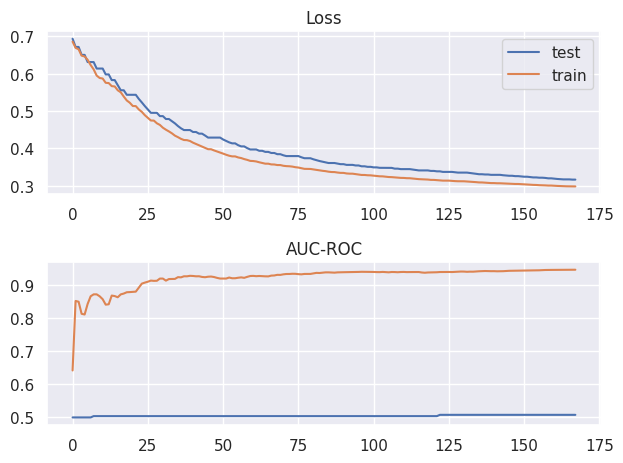

In [28]:
boosting.plot_history(X_valid, y_valid, label='test')

Text(0.5, 1.0, 'Loss')

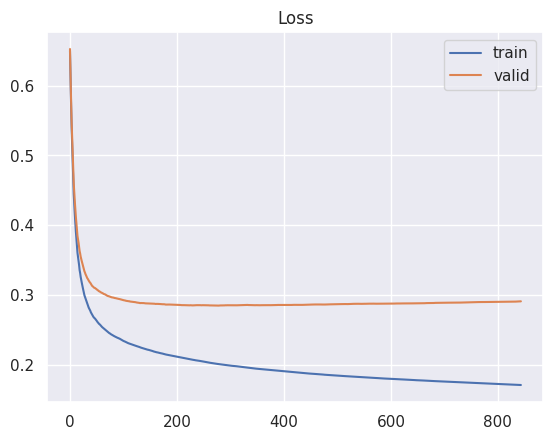

In [35]:
evals_result = model.get_evals_result()
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation']['Logloss']
fig, axes = plt.subplots(1)
axes.plot(train_loss, label='train')
axes.plot(test_loss, label='valid')
axes.legend()
axes.set_title('Loss')

3 минуты 11 секунд против 5 секунд

<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: catboost - дал лучший результат + обучение не идет полгода</font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [40]:
!pip install lightgbm

In [48]:
from lightgbm import LGBMClassifier
def objective(trial, model="custom_boosting"):
    # параметры, общие для всех бустингов
    common_params = {
        "boosting_type": 'rf',
        "num_leaves": trial.suggest_int("num_leaves", 20, 500),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 0.7)
    }
    # параметры для конкретной имплементации бустинга
    optional_params = {}
    params = common_params | optional_params
    np.random.seed(1337)
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set = (X_valid, y_valid))
    return log_loss(y_valid, model.predict_proba(X_valid)[:, 1])

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective, n_trials=25, timeout=300)

print("Best params:", study_rf.best_params)
print("Best loss:", study_rf.best_value)

[I 2024-12-22 20:30:44,577] A new study created in memory with name: no-name-951fd7f2-1324-4a30-968d-eb8883ef79d4


[LightGBM] [Warning] feature_fraction is set=0.6474572681466972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474572681466972
[LightGBM] [Warning] bagging_fraction is set=0.6915546571118633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915546571118633
[LightGBM] [Warning] feature_fraction is set=0.6474572681466972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474572681466972
[LightGBM] [Warning] bagging_fraction is set=0.6915546571118633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915546571118633
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:30:45,230] Trial 0 finished with value: 0.35181394120004106 and parameters: {'num_leaves': 85, 'max_depth': 9, 'n_estimators': 143, 'bagging_fraction': 0.6915546571118633, 'feature_fraction': 0.6474572681466972}. Best is trial 0 with value: 0.35181394120004106.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6474572681466972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6474572681466972
[LightGBM] [Warning] bagging_fraction is set=0.6915546571118633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6915546571118633
[LightGBM] [Warning] feature_fraction is set=0.6036095254736222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6036095254736222
[LightGBM] [Warning] bagging_fraction is set=0.6506910170085806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6506910170085806
[LightGBM] [Warning] feature_fraction is set=0.6036095254736222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6036095254736222
[LightGBM] [Warning] bagging_fraction is set=0.6506910170085806, subsample=1.0 will be ignored

[I 2024-12-22 20:30:45,977] Trial 1 finished with value: 0.3656650021367362 and parameters: {'num_leaves': 33, 'max_depth': 9, 'n_estimators': 274, 'bagging_fraction': 0.6506910170085806, 'feature_fraction': 0.6036095254736222}. Best is trial 0 with value: 0.35181394120004106.


[LightGBM] [Warning] feature_fraction is set=0.6036095254736222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6036095254736222
[LightGBM] [Warning] bagging_fraction is set=0.6506910170085806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6506910170085806
[LightGBM] [Warning] feature_fraction is set=0.5927620319713065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5927620319713065
[LightGBM] [Warning] bagging_fraction is set=0.6978347909896174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6978347909896174
[LightGBM] [Warning] feature_fraction is set=0.5927620319713065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5927620319713065
[LightGBM] [Warning] bagging_fraction is set=0.6978347909896174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6978347909896174
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:30:47,972] Trial 2 finished with value: 0.36972997030428395 and parameters: {'num_leaves': 190, 'max_depth': 6, 'n_estimators': 535, 'bagging_fraction': 0.6978347909896174, 'feature_fraction': 0.5927620319713065}. Best is trial 0 with value: 0.35181394120004106.


[LightGBM] [Warning] feature_fraction is set=0.5927620319713065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5927620319713065
[LightGBM] [Warning] bagging_fraction is set=0.6978347909896174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6978347909896174
[LightGBM] [Warning] feature_fraction is set=0.5337022961850797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5337022961850797
[LightGBM] [Warning] bagging_fraction is set=0.6774371524359782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774371524359782
[LightGBM] [Warning] feature_fraction is set=0.5337022961850797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5337022961850797
[LightGBM] [Warning] bagging_fraction is set=0.6774371524359782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774371524359782
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:30:50,034] Trial 3 finished with value: 0.4102601799345255 and parameters: {'num_leaves': 169, 'max_depth': 3, 'n_estimators': 991, 'bagging_fraction': 0.6774371524359782, 'feature_fraction': 0.5337022961850797}. Best is trial 0 with value: 0.35181394120004106.


[LightGBM] [Warning] feature_fraction is set=0.5337022961850797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5337022961850797
[LightGBM] [Warning] bagging_fraction is set=0.6774371524359782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774371524359782
[LightGBM] [Warning] feature_fraction is set=0.6940676222448887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940676222448887
[LightGBM] [Warning] bagging_fraction is set=0.5060076617733094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060076617733094
[LightGBM] [Warning] feature_fraction is set=0.6940676222448887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940676222448887
[LightGBM] [Warning] bagging_fraction is set=0.5060076617733094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060076617733094
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:30:53,380] Trial 4 finished with value: 0.34222941779221183 and parameters: {'num_leaves': 398, 'max_depth': 10, 'n_estimators': 297, 'bagging_fraction': 0.5060076617733094, 'feature_fraction': 0.6940676222448887}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6940676222448887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6940676222448887
[LightGBM] [Warning] bagging_fraction is set=0.5060076617733094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5060076617733094
[LightGBM] [Warning] feature_fraction is set=0.6971571383701388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971571383701388
[LightGBM] [Warning] bagging_fraction is set=0.51925400796855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51925400796855
[LightGBM] [Warning] feature_fraction is set=0.6971571383701388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6971571383701388
[LightGBM] [Warning] bagging_fraction is set=0.51925400796855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.51925400796855
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row

[I 2024-12-22 20:30:55,699] Trial 5 finished with value: 0.37642280059752564 and parameters: {'num_leaves': 133, 'max_depth': 4, 'n_estimators': 717, 'bagging_fraction': 0.51925400796855, 'feature_fraction': 0.6971571383701388}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6593000333029234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6593000333029234
[LightGBM] [Warning] bagging_fraction is set=0.5469533695205199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5469533695205199
[LightGBM] [Warning] feature_fraction is set=0.6593000333029234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6593000333029234
[LightGBM] [Warning] bagging_fraction is set=0.5469533695205199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5469533695205199
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:30:59,431] Trial 6 finished with value: 0.3489684410246283 and parameters: {'num_leaves': 93, 'max_depth': 9, 'n_estimators': 791, 'bagging_fraction': 0.5469533695205199, 'feature_fraction': 0.6593000333029234}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6703353646746698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703353646746698
[LightGBM] [Warning] bagging_fraction is set=0.5496050095191742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5496050095191742
[LightGBM] [Warning] feature_fraction is set=0.6703353646746698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6703353646746698
[LightGBM] [Warning] bagging_fraction is set=0.5496050095191742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5496050095191742
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:00,712] Trial 7 finished with value: 0.46160970804259915 and parameters: {'num_leaves': 241, 'max_depth': 1, 'n_estimators': 900, 'bagging_fraction': 0.5496050095191742, 'feature_fraction': 0.6703353646746698}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6004440831088814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004440831088814
[LightGBM] [Warning] bagging_fraction is set=0.6646288434290771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6646288434290771
[LightGBM] [Warning] feature_fraction is set=0.6004440831088814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6004440831088814
[LightGBM] [Warning] bagging_fraction is set=0.6646288434290771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6646288434290771
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:04,899] Trial 8 finished with value: 0.35893309577984706 and parameters: {'num_leaves': 349, 'max_depth': 8, 'n_estimators': 401, 'bagging_fraction': 0.6646288434290771, 'feature_fraction': 0.6004440831088814}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6385242527411191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385242527411191
[LightGBM] [Warning] bagging_fraction is set=0.6365898605276495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6365898605276495
[LightGBM] [Warning] feature_fraction is set=0.6385242527411191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385242527411191
[LightGBM] [Warning] bagging_fraction is set=0.6365898605276495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6365898605276495
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScor

[I 2024-12-22 20:31:06,808] Trial 9 finished with value: 0.3610190679575098 and parameters: {'num_leaves': 37, 'max_depth': 7, 'n_estimators': 250, 'bagging_fraction': 0.6365898605276495, 'feature_fraction': 0.6385242527411191}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6385242527411191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6385242527411191
[LightGBM] [Warning] bagging_fraction is set=0.6365898605276495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6365898605276495
[LightGBM] [Warning] feature_fraction is set=0.5007029163486009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007029163486009
[LightGBM] [Warning] bagging_fraction is set=0.5934488176070478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5934488176070478
[LightGBM] [Warning] feature_fraction is set=0.5007029163486009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5007029163486009
[LightGBM] [Warning] bagging_fraction is set=0.5934488176070478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5934488176070478
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:31:13,151] Trial 10 finished with value: 0.37052461044252605 and parameters: {'num_leaves': 485, 'max_depth': 10, 'n_estimators': 520, 'bagging_fraction': 0.5934488176070478, 'feature_fraction': 0.5007029163486009}. Best is trial 4 with value: 0.34222941779221183.


[LightGBM] [Warning] feature_fraction is set=0.6989363487464584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6989363487464584
[LightGBM] [Warning] bagging_fraction is set=0.5112722793802833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5112722793802833
[LightGBM] [Warning] feature_fraction is set=0.6989363487464584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6989363487464584
[LightGBM] [Warning] bagging_fraction is set=0.5112722793802833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5112722793802833
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:25,926] Trial 11 finished with value: 0.3417749455358627 and parameters: {'num_leaves': 374, 'max_depth': 10, 'n_estimators': 740, 'bagging_fraction': 0.5112722793802833, 'feature_fraction': 0.6989363487464584}. Best is trial 11 with value: 0.3417749455358627.


[LightGBM] [Warning] feature_fraction is set=0.6987973165664811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987973165664811
[LightGBM] [Warning] bagging_fraction is set=0.5121195319752788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5121195319752788
[LightGBM] [Warning] feature_fraction is set=0.6987973165664811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987973165664811
[LightGBM] [Warning] bagging_fraction is set=0.5121195319752788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5121195319752788
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:34,466] Trial 12 finished with value: 0.34162311176757326 and parameters: {'num_leaves': 361, 'max_depth': 10, 'n_estimators': 682, 'bagging_fraction': 0.5121195319752788, 'feature_fraction': 0.6987973165664811}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6996903616733668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6996903616733668
[LightGBM] [Warning] bagging_fraction is set=0.5747337935891846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5747337935891846
[LightGBM] [Warning] feature_fraction is set=0.6996903616733668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6996903616733668
[LightGBM] [Warning] bagging_fraction is set=0.5747337935891846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5747337935891846
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:39,297] Trial 13 finished with value: 0.35123958353215945 and parameters: {'num_leaves': 336, 'max_depth': 7, 'n_estimators': 677, 'bagging_fraction': 0.5747337935891846, 'feature_fraction': 0.6996903616733668}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6271242669385305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6271242669385305
[LightGBM] [Warning] bagging_fraction is set=0.5342559356620061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342559356620061
[LightGBM] [Warning] feature_fraction is set=0.6271242669385305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6271242669385305
[LightGBM] [Warning] bagging_fraction is set=0.5342559356620061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342559356620061
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:41,413] Trial 14 finished with value: 0.37185829748518406 and parameters: {'num_leaves': 448, 'max_depth': 5, 'n_estimators': 646, 'bagging_fraction': 0.5342559356620061, 'feature_fraction': 0.6271242669385305}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6271242669385305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6271242669385305
[LightGBM] [Warning] bagging_fraction is set=0.5342559356620061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5342559356620061
[LightGBM] [Warning] feature_fraction is set=0.5656008739135862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5656008739135862
[LightGBM] [Warning] bagging_fraction is set=0.5040079850806765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5040079850806765
[LightGBM] [Warning] feature_fraction is set=0.5656008739135862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5656008739135862
[LightGBM] [Warning] bagging_fraction is set=0.5040079850806765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5040079850806765
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:31:47,557] Trial 15 finished with value: 0.35848894677374543 and parameters: {'num_leaves': 290, 'max_depth': 10, 'n_estimators': 829, 'bagging_fraction': 0.5040079850806765, 'feature_fraction': 0.5656008739135862}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6705635425945398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6705635425945398
[LightGBM] [Warning] bagging_fraction is set=0.5736163533575341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5736163533575341
[LightGBM] [Warning] feature_fraction is set=0.6705635425945398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6705635425945398
[LightGBM] [Warning] bagging_fraction is set=0.5736163533575341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5736163533575341
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:51,856] Trial 16 finished with value: 0.34831851402220837 and parameters: {'num_leaves': 402, 'max_depth': 8, 'n_estimators': 601, 'bagging_fraction': 0.5736163533575341, 'feature_fraction': 0.6705635425945398}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6776150844947598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776150844947598
[LightGBM] [Warning] bagging_fraction is set=0.6208411334453355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6208411334453355
[LightGBM] [Warning] feature_fraction is set=0.6776150844947598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6776150844947598
[LightGBM] [Warning] bagging_fraction is set=0.6208411334453355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6208411334453355
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:31:52,869] Trial 17 finished with value: 0.4613794911663278 and parameters: {'num_leaves': 285, 'max_depth': 1, 'n_estimators': 443, 'bagging_fraction': 0.6208411334453355, 'feature_fraction': 0.6776150844947598}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-22 20:31:58,125] Trial 18 finished with value: 0.3536515248118177 and parameters: {'num_leaves': 353, 'max_depth': 8, 'n_estimators': 758, 'bagging_fraction': 0.5313877089365724, 'feature_fraction': 0.6250590847556382}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.5779937443753712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5779937443753712
[LightGBM] [Warning] bagging_fraction is set=0.5647787050803219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647787050803219
[LightGBM] [Warning] feature_fraction is set=0.5779937443753712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5779937443753712
[LightGBM] [Warning] bagging_fraction is set=0.5647787050803219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647787050803219
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:32:01,518] Trial 19 finished with value: 0.37241903422821304 and parameters: {'num_leaves': 414, 'max_depth': 6, 'n_estimators': 885, 'bagging_fraction': 0.5647787050803219, 'feature_fraction': 0.5779937443753712}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6834320162540969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6834320162540969
[LightGBM] [Warning] bagging_fraction is set=0.5966587563520203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966587563520203
[LightGBM] [Warning] feature_fraction is set=0.6834320162540969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6834320162540969
[LightGBM] [Warning] bagging_fraction is set=0.5966587563520203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5966587563520203
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:32:02,806] Trial 20 finished with value: 0.3916367532061802 and parameters: {'num_leaves': 225, 'max_depth': 3, 'n_estimators': 584, 'bagging_fraction': 0.5966587563520203, 'feature_fraction': 0.6834320162540969}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-22 20:32:07,134] Trial 21 finished with value: 0.3426633742439076 and parameters: {'num_leaves': 398, 'max_depth': 10, 'n_estimators': 382, 'bagging_fraction': 0.5008242241883123, 'feature_fraction': 0.694653858314951}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6579610869989996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579610869989996
[LightGBM] [Warning] bagging_fraction is set=0.5135492976293345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5135492976293345
[LightGBM] [Warning] feature_fraction is set=0.6579610869989996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579610869989996
[LightGBM] [Warning] bagging_fraction is set=0.5135492976293345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5135492976293345
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

[I 2024-12-22 20:32:09,418] Trial 22 finished with value: 0.34595452922198633 and parameters: {'num_leaves': 480, 'max_depth': 10, 'n_estimators': 229, 'bagging_fraction': 0.5135492976293345, 'feature_fraction': 0.6579610869989996}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6579610869989996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579610869989996
[LightGBM] [Warning] bagging_fraction is set=0.5135492976293345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5135492976293345
[LightGBM] [Warning] feature_fraction is set=0.6837573161091817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6837573161091817
[LightGBM] [Warning] bagging_fraction is set=0.5254609202430339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5254609202430339
[LightGBM] [Warning] feature_fraction is set=0.6837573161091817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6837573161091817
[LightGBM] [Warning] bagging_fraction is set=0.5254609202430339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5254609202430339
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:32:12,537] Trial 23 finished with value: 0.3459149274001673 and parameters: {'num_leaves': 333, 'max_depth': 9, 'n_estimators': 457, 'bagging_fraction': 0.5254609202430339, 'feature_fraction': 0.6837573161091817}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6837573161091817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6837573161091817
[LightGBM] [Warning] bagging_fraction is set=0.5254609202430339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5254609202430339
[LightGBM] [Warning] feature_fraction is set=0.6611844515209476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611844515209476
[LightGBM] [Warning] bagging_fraction is set=0.5493976539617321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5493976539617321
[LightGBM] [Warning] feature_fraction is set=0.6611844515209476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611844515209476
[LightGBM] [Warning] bagging_fraction is set=0.5493976539617321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5493976539617321
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choo

[I 2024-12-22 20:32:13,327] Trial 24 finished with value: 0.34917319129524 and parameters: {'num_leaves': 432, 'max_depth': 10, 'n_estimators': 101, 'bagging_fraction': 0.5493976539617321, 'feature_fraction': 0.6611844515209476}. Best is trial 12 with value: 0.34162311176757326.


[LightGBM] [Warning] feature_fraction is set=0.6611844515209476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611844515209476
[LightGBM] [Warning] bagging_fraction is set=0.5493976539617321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5493976539617321
Best params: {'num_leaves': 361, 'max_depth': 10, 'n_estimators': 682, 'bagging_fraction': 0.5121195319752788, 'feature_fraction': 0.6987973165664811}
Best loss: 0.34162311176757326


In [50]:
rf = LGBMClassifier(**study_rf.best_params)
rf.fit(X_train, y_train, eval_set = (X_valid, y_valid))

[LightGBM] [Warning] feature_fraction is set=0.6987973165664811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987973165664811
[LightGBM] [Warning] bagging_fraction is set=0.5121195319752788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5121195319752788
[LightGBM] [Warning] feature_fraction is set=0.6987973165664811, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6987973165664811
[LightGBM] [Warning] bagging_fraction is set=0.5121195319752788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5121195319752788
[LightGBM] [Info] Number of positive: 12243, number of negative: 6582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 18825, numb

LGBMClassifier(bagging_fraction=0.5121195319752788,
               feature_fraction=0.6987973165664811, max_depth=10,
               n_estimators=682, num_leaves=361)

Text(0.5, 1.0, 'Loss')

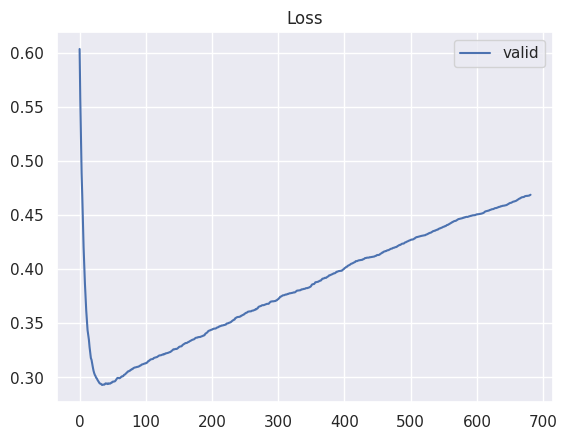

In [59]:
evals_result = rf.evals_result_
test_loss = evals_result['valid_0']['binary_logloss']
fig, axes = plt.subplots(1)
axes.plot(test_loss, label='valid')
axes.legend()
axes.set_title('Loss')

Значительно хуже, не нужен.

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

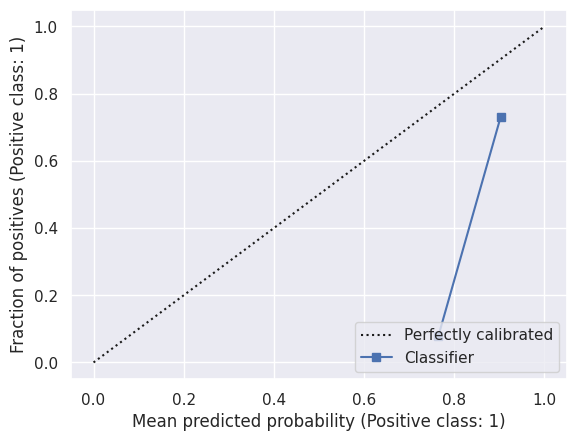

In [37]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_test, boosting.predict_proba(X_test)[:,1])


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

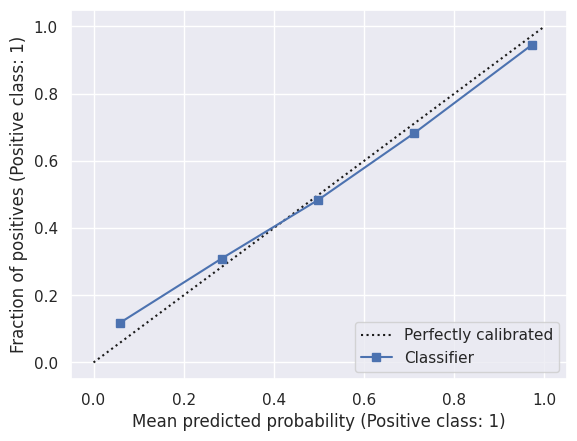

In [39]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
disp = CalibrationDisplay.from_predictions(y_test,model_log.predict_proba(X_test)[:,1])

Значительно хуже, что не удивительно, так как мы в дереве одновоременно используем и логистическую регрессию и сигмоиду сверху. Из-за чего получаем сомнительный результат.

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2025 года?

Я жду тольк покоя, умиротворения и оффер в компанию.

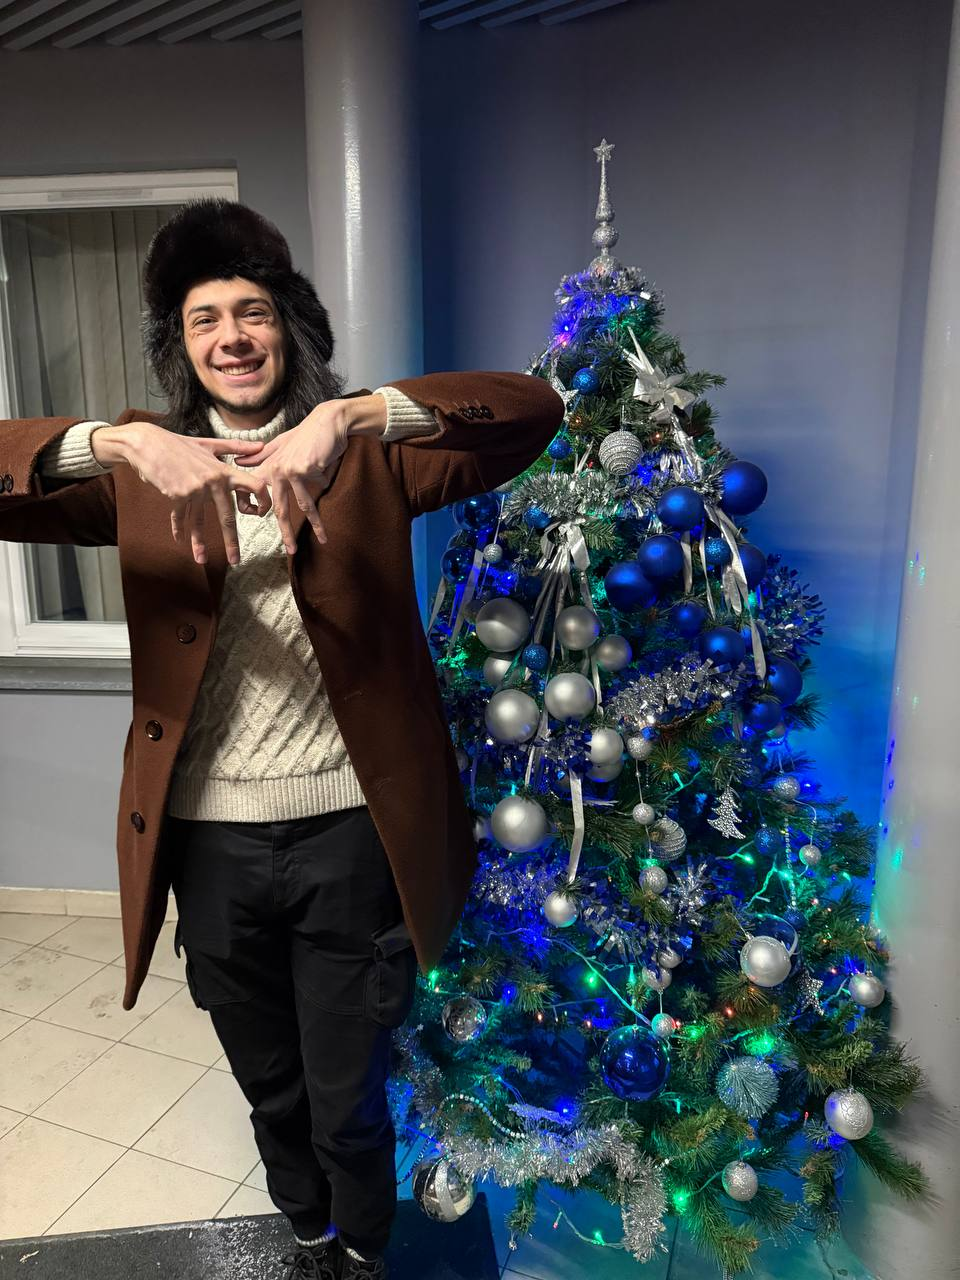